In [1]:
import gym
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import time
import sys
import math
import seaborn as sns

In [2]:
env = gym.make('CartPole-v0')

## Reinforcement Learning: Table form Q-learning 

### Hyper Parameters
- **nbins** is number of discretization you can do, currently maximum of 98
- **GAMMA** is the discount factor
-  **ALPHA** is the learning rate

In [3]:
nbins = 10
GAMMA = 0.9
ALPHA = 0.01

Here we define some functions for running the tabular Q learning with greedy epsilon strategy.

*Reference: * Phil Tabor, OpenAI-Cartpole, (2017), GitHub repository, https://github.com/philtabor/OpenAI-Cartpole

In [4]:
def max_dict(d): 
    """
    looking for the action that gives the maximum value for a given state
    """
    max_v = float('-inf')
    for key, val in d.items():
        if val > max_v:
            max_v = val
            max_key = key
    return max_key, max_v

In [5]:
def create_bins(): 
    """
    create bins to discretize the continuous observable state space
    """
    # obs[0] -> cart position --- -4.8 - 4.8
    # obs[1] -> cart velocity --- -inf - inf
    # obs[2] -> pole angle    --- -41.8 - 41.8
    # obs[3] -> pole velocity --- -inf - inf

    bins = np.zeros((4,nbins))
    bins[0] = np.linspace(-4.8, 4.8, nbins)
    bins[1] = np.linspace(-5, 5, nbins)
    bins[2] = np.linspace(-.418, .418, nbins)
    bins[3] = np.linspace(-5, 5, nbins)
    return bins

In [6]:
def assign_bins(observation, bins): 
    """
    discretizing the continuous observation space into state
    """
    state = np.zeros(4)
    for i in range(4):
        state[i] = np.digitize(observation[i], bins[i])
    return state

In [7]:
def get_state_as_string(state):
    """
    encoding the state into string as dictionary
    """
    string_state=''
    for e in state:
            string_state = string_state+str(int(e)).zfill(2)
    return string_state

In [8]:
def get_all_states_as_string():
    states = []
    for i in range (nbins+1):
        for j in range (nbins+1):
            for k in range(nbins+1):
                for l in range(nbins+1):
                    a=str(i).zfill(2)+str(j).zfill(2)+str(k).zfill(2)+str(l).zfill(2)
                    states.append(a)
    return states

In [9]:
def initialize_Q():
    """
    initialize your Q table
    """
    Q = {}

    all_states = get_all_states_as_string()
    for state in all_states:
        Q[state] = {}
        for action in range(env.action_space.n):
            Q[state][action] = 0
    return Q

In [10]:
def play_one_game(bins, Q, eps=0.5):
    """
    train 1 episode
    """
    observation = env.reset()
    done = False
    cnt = 0 # number of moves in an episode
    state = get_state_as_string(assign_bins(observation, bins))
    total_reward = 0

    while not done:
        cnt += 1
        # np.random.randn() seems to yield a random action 50% of the time ?
        if np.random.uniform() < eps:
            act = env.action_space.sample() # epsilon greedy
        else:
            act = max_dict(Q[state])[0]

        observation, reward, done, _ = env.step(act)

        total_reward += reward

        if done and cnt < 200:
            reward = -300

        state_new = get_state_as_string(assign_bins(observation, bins))

        a1, max_q_s1a1 = max_dict(Q[state_new])
        Q[state][act] += ALPHA*(reward + GAMMA*max_q_s1a1 - Q[state][act])
        state, act = state_new, a1

    return total_reward, cnt

In [11]:
def play_many_games(bins, N=10000):
    """
    train many episodes
    """
    Q = initialize_Q()

    length = []
    reward = []
    for n in range(N):
        #eps=0.5/(1+n*10e-3)
        eps = 1.0 / np.sqrt(n+1)

        episode_reward, episode_length= play_one_game(bins, Q, eps)

        if n % 100 == 0:
            clear_output(wait=True)
            print("Episode: %d, Epislon: %.4f, Reward %d"%(n,eps,episode_reward))
        length.append(episode_length)
        reward.append(episode_reward)
    env.close()
    return length, reward, Q

In [12]:
def plot_running_avg(totalrewards,title='Running Average',save=False,name='result'):
    """
    plotting the average reward during training
    """
    fig=plt.figure()
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Duration")
#     plt.grid()
    if save:
        plt.savefig(name+'.png',bbox_inches='tight')
    else:
        plt.show()

In [13]:
def play_policy(bins,Q,N=1000,render=False,delay=0.01):
    """
    run an environment using a trained policy
    """
    
    totalReward=[]
    steps=[]
    for n in range(N):
        observation=env.reset()
        done=False
        episodeReward=0
        while not done:
            if render:
                env.render()
                time.sleep(delay)
            state=get_state_as_string(assign_bins(observation, bins))
            act=max_dict(Q[state])[0]
            observation,reward,done,_=env.step(act)
            episodeReward+=reward
        totalReward.append(episodeReward)
    env.close()
    return totalReward

## Finding Expert Policy

Here we train a tradition Q-learning to use as the expert policy that we want the apprenticeship IRL algorithm to learn from. The reward obtained from each state-action pair is stored in a 10000 x 2 array, where the rows are the states and columns are the actions. Each cell is a reward associated with the state-action pair. The algorithm uses epislon-greedy approach choose its actions, and updates its Q table through the training iterations. This Q table is the policy.

In [14]:
bins = create_bins()
episode_lengths, episode_rewards, expert_Q=play_many_games(bins,N=20000)

print("export trained expert model...")
filename = 'expert_Q'
outfile = open(filename,'wb')
pickle.dump(expert_Q,outfile)
outfile.close()

#plot_running_avg(episode_rewards,title="Performance: Expert",save=True,name='Expert')

Episode: 19900, Epislon: 0.0071, Reward 200
export trained expert model...


### Demonstrate Expert Policy

Here we show the training result. Using the trained policy, we run the environment 10000 times to sample the reward distribution. 

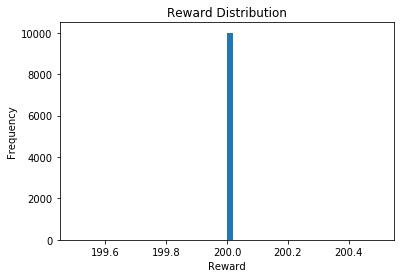

In [15]:
expertReward=play_policy(bins,expert_Q,N=10000,render=False)

plt.hist(expertReward,bins=50)
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
unique, counts = np.unique(expertReward, return_counts=True)

We render the environment to visualize the policy in action.

In [16]:
expertReward=play_policy(bins,expert_Q,N=1,render=True,delay=0.05)